In [1]:
# Imports
from __future__ import annotations

from dataclasses import dataclass
from typing import Callable

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

In [2]:
# Config
DATA_FILE = '/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/combined_filtered_annotated_docking_results.parquet'

DRUG_COL = 'drugbank_id'
TGT_COL = 'uniprot_id'
LABEL_COL = 'sample_type'  # positive / negative_balanced
PAIR_COL = 'compound_target_pair'

# Pocket similarity column preference
POCKET_COL_CANDIDATES = ['louvain_cluster_pmax04', 'cavity_cluster_id']

# Direct score columns and their direction: invert=True means lower is better.
# We standardize to "higher is better" by flipping sign when invert=True.
DIRECT_TOOL_SCORES = [
    ('GNINA', 'GNINA_Score', True),
    ('SMINA', 'Smina_Score', True),
    ('LEDOCK', 'Ledock_Score', True),
    ('GOLD', 'GOLD_Score', False),
]

# Option A (strict): parse Tool1/Score1 and Tool2/Score2 only if a complete invert map is provided.
INCLUDE_TOOL_PAIR_COLS = False  # set True to include Tool1/Tool2 scores
TOOL_PAIR_COLS = [('Tool1', 'Score1'), ('Tool2', 'Score2')]
TOOL_INVERT_MAP = {
    # Example (fill in if INCLUDE_TOOL_PAIR_COLS=True):
    # 'gnina': True,
    # 'smina': True,
    # 'ledock': True,
    # 'gold': False,
}

RANDOM_SEED = 1337
N_BOOTSTRAP = 300
BOOTSTRAP_GROUP_COL = DRUG_COL

AGGREGATIONS = ['best', 'median']

# Ranking vs decoys
DECOY_NS = [50, 200]
TOP_KS = [1, 5, 10]

# Stratification thresholds
MIN_POS_PER_CLUSTER = 20
MIN_NEG_PER_CLUSTER = 20

In [3]:
# Load parquet (Polars)
df = pl.scan_parquet(DATA_FILE).collect()

# Replace all NoneType values in louvain_cluster_pmax* columns with -1
for col in df.columns:
    if col.startswith('louvain_cluster_pmax'):
        df = df.with_columns(
            pl.when(pl.col(col).is_null())
            .then(-1)
            .otherwise(pl.col(col))
            .alias(col)
        )

# TEMPORARY: take only high confidence pose consensus columns, if RMSD >= 2.0 Å
df = df.filter(pl.col('RMSD') < 1.5)
# TEMPORARY: take only one cluster from the louvain_cluster_pmax04
#df = df.filter(pl.col('louvain_cluster_pmax04') == 3)

print('Rows:', df.height)
print('Columns:', len(df.columns))
df.head(3)

Rows: 43686
Columns: 83


Tool1,Tool2,PoseNumber1,PoseNumber2,Score1,Score2,File1,File2,RMSD,source_file,source_dir,file_size_mb,source_type,drugbank_id,uniprot_id,gene_name,cavity_index,Pose,SMINA_Score,Score,S(PLP),S(hbond),S(cho),S(metal),DE(clash),DE(tors),time,LeDock_Score,primary_tool,compound_target_pair,sample_type,Gene_Name,dta_n_rows,dta_entry_id,dta_DeepDTA_kd,dta_DeepDTA_ki,dta_DeepDTA_ic50,…,dta_MLTLE_GCN_kd,dta_MLTLE_GCN_ki,dta_MLTLE_GCN_ic50,dta_MLTLE_GIN_kd,dta_MLTLE_GIN_ki,dta_MLTLE_GIN_ic50,dta_avg_kd,dta_avg_ki,dta_avg_ic50,dta_ci_kd,dta_ci_ki,dta_ci_ic50,GOLD_Score,GNINA_Score,extracted_uniprot_id,extracted_cavity_index,cavity_cluster_id,ic50_value,ic50_unit,measurement_type,operator,pubchem_cid,activity,n_measurements,pocket_id,louvain_cluster_pmax03,louvain_cluster_size_pmax03,louvain_cluster_pmax04,louvain_cluster_size_pmax04,louvain_cluster_pmax05,louvain_cluster_size_pmax05,louvain_cluster_pmax06,louvain_cluster_size_pmax06,louvain_cluster_pmax07,louvain_cluster_size_pmax07,louvain_cluster_pmax08,louvain_cluster_size_pmax08
str,str,f64,f64,f64,f64,str,str,f64,str,str,f64,str,str,str,str,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f32,str,str,str,str,i64,str,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,i64,f64,f64,str,str,str,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SMINA""","""GNINA""",5.0,13.0,-10.7163,-11.46,"""complex_5.pdb""","""complex_13.pdb""",0.532886,"""final_results.csv""","""/media/onur/Elements/cavity_sp…",0.180775,"""final_results""","""DB00157""","""Q15392""","""DHCR7""",4.0,null,-10.7163,null,null,null,null,null,null,null,null,null,"""Consensus""","""DB00157_Q15392""","""positive""","""DHCR7""",1,"""Q15392_DB00157""",5.8062,7.6513,6.2603,…,7.6721,5.3179,6.3809,5.4548,5.2111,6.0834,6.326321,5.813908,6.040665,6.340343,5.777638,6.032129,null,-11.46,"""Q15392""",4,null,null,null,null,null,null,null,null,"""AF-Q15392-F1-model_v1_cavity_4…",1.0,1547.0,3.0,3062.0,2.0,2791.0,5.0,2681.0,6.0,1759.0,11.0,1368.0
"""SMINA""","""GNINA""",4.0,12.0,-11.08575,-9.92,"""complex_4.pdb""","""complex_12.pdb""",1.416232,"""final_results.csv""","""/media/onur/Elements/cavity_sp…",0.180386,"""final_results""","""DB00157""","""P00325""","""ADH1C""",1.0,null,-11.08575,null,null,null,null,null,null,null,null,null,"""Consensus""","""DB00157_P00325""","""positive""","""ADH1C""",1,"""P00325_DB00157""",5.5469,7.4638,5.6053,…,8.1212,5.0483,5.8865,8.4112,5.6544,6.749,6.786833,5.779506,5.831046,6.84186,5.731791,5.828385,null,-9.92,"""P00325""",1,6.0,null,null,null,null,null,null,null,"""AF-P00325-F1-model_v1_cavity_1…",3.0,1507.0,1.0,2747.0,1.0,2676.0,2.0,2025.0,3.0,1268.0,8.0,705.0
"""SMINA""","""GNINA""",2.0,10.0,-11.48509,-11.09,"""complex_2.pdb""","""complex_10.pdb""",0.700532,"""final_results.csv""","""/media/onur/Elements/cavity_sp…",0.17998,"""final_results""","""DB00157""","""Q92781""","""RDH5""",2.0,null,-11.48509,null,null,null,null,null,null,null,null,null,"""Consensus""","""DB00157_Q92781""","""positive""","""RDH5""",1,"""Q92781_DB00157""",5.4827,4.9517,5.4546,…,6.7808,5.538,5.7646,5.0481,5.8711,5.52,6.178475,5.860865,5.622599,6.18822,5.90358,5.632445,null,-11.09,"""Q92781""",2,33.0,null,null,null,null,null,null,null,"""AF-Q92781-F1-model_v1_cavity_2…",2.0,3860.0,1.0,2747.0,1.0,2676.0,2.0,2025.0,3.0,1268.0,8.0,705.0


In [48]:
# Basic validation, derived columns, and class balance
required = [DRUG_COL, TGT_COL, LABEL_COL]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f'Missing required columns: {missing}')

pocket_col = next((c for c in POCKET_COL_CANDIDATES if c in df.columns), None)
print('Pocket column used:', pocket_col)

if PAIR_COL not in df.columns:
    df = df.with_columns((pl.col(DRUG_COL).cast(pl.Utf8) + pl.lit('_') + pl.col(TGT_COL).cast(pl.Utf8)).alias(PAIR_COL))

df = df.filter(pl.col(LABEL_COL).is_in(['positive', 'negative_balanced']))

print('Row-level class counts:')
print(df.group_by(LABEL_COL).len().sort('len', descending=True))

print('Unique pair-level class counts:')
df_pairs = df.select([PAIR_COL, LABEL_COL]).unique()
print(df_pairs.group_by(LABEL_COL).len().sort('len', descending=True))

Pocket column used: louvain_cluster_pmax04
Row-level class counts:
shape: (2, 2)
┌───────────────────┬───────┐
│ sample_type       ┆ len   │
│ ---               ┆ ---   │
│ str               ┆ u32   │
╞═══════════════════╪═══════╡
│ negative_balanced ┆ 23839 │
│ positive          ┆ 19828 │
└───────────────────┴───────┘
Unique pair-level class counts:
shape: (2, 2)
┌───────────────────┬──────┐
│ sample_type       ┆ len  │
│ ---               ┆ ---  │
│ str               ┆ u32  │
╞═══════════════════╪══════╡
│ negative_balanced ┆ 2463 │
│ positive          ┆ 1303 │
└───────────────────┴──────┘


In [49]:
unique_drugs = df.select(pl.col(DRUG_COL)).unique()

In [50]:
# Take only the best (per-tool) and non-NaN score per compound-target pair
# - GNINA / SMINA / LeDock: lower is better => take MIN
# - GOLD: higher is better => take MAX

# Ensure PAIR_COL exists at this point in the notebook
if PAIR_COL not in df.columns:
    df = df.with_columns(
        (pl.col(DRUG_COL).cast(pl.Utf8) + pl.lit("_") + pl.col(TGT_COL).cast(pl.Utf8)).alias(PAIR_COL)
    )

_extra_cols = [c for c in ["cavity_cluster_id", "louvain_cluster_pmax03","louvain_cluster_pmax04",
                           "louvain_cluster_pmax05","louvain_cluster_pmax06","louvain_cluster_pmax07",
                           "louvain_cluster_pmax08","ic50_value"] if c in df.columns]

def _pair_best_score(df_in: pl.DataFrame, score_col: str, best: str) -> pl.DataFrame:
    if score_col not in df_in.columns:
        print(f"Warning: column not found, skipping: {score_col}")
        return pl.DataFrame()

    if best not in {"min", "max"}:
        raise ValueError("best must be 'min' or 'max'")

    agg_score = (pl.min(score_col) if best == "min" else pl.max(score_col)).alias(score_col)

    return (
        df_in
        .filter(pl.col(score_col).is_not_null() & pl.col(score_col).is_finite())
        .group_by(PAIR_COL)
        .agg([
            pl.first(DRUG_COL).alias(DRUG_COL),
            pl.first(TGT_COL).alias(TGT_COL),
            pl.first(LABEL_COL).alias(LABEL_COL),
            agg_score,
            *[pl.first(c).alias(c) for c in _extra_cols],
        ])
    )

df_gnina  = _pair_best_score(df, "GNINA_Score",  best="min")
df_smina  = _pair_best_score(df, "SMINA_Score",  best="min")
df_ledock = _pair_best_score(df, "Ledock_Score", best="min")
df_gold   = _pair_best_score(df, "GOLD_Score",   best="max")

print("Pair-level rows:",
      {"GNINA": df_gnina.height, "SMINA": df_smina.height, "LEDOCK": df_ledock.height, "GOLD": df_gold.height})

Pair-level rows: {'GNINA': 3556, 'SMINA': 3524, 'LEDOCK': 0, 'GOLD': 1902}


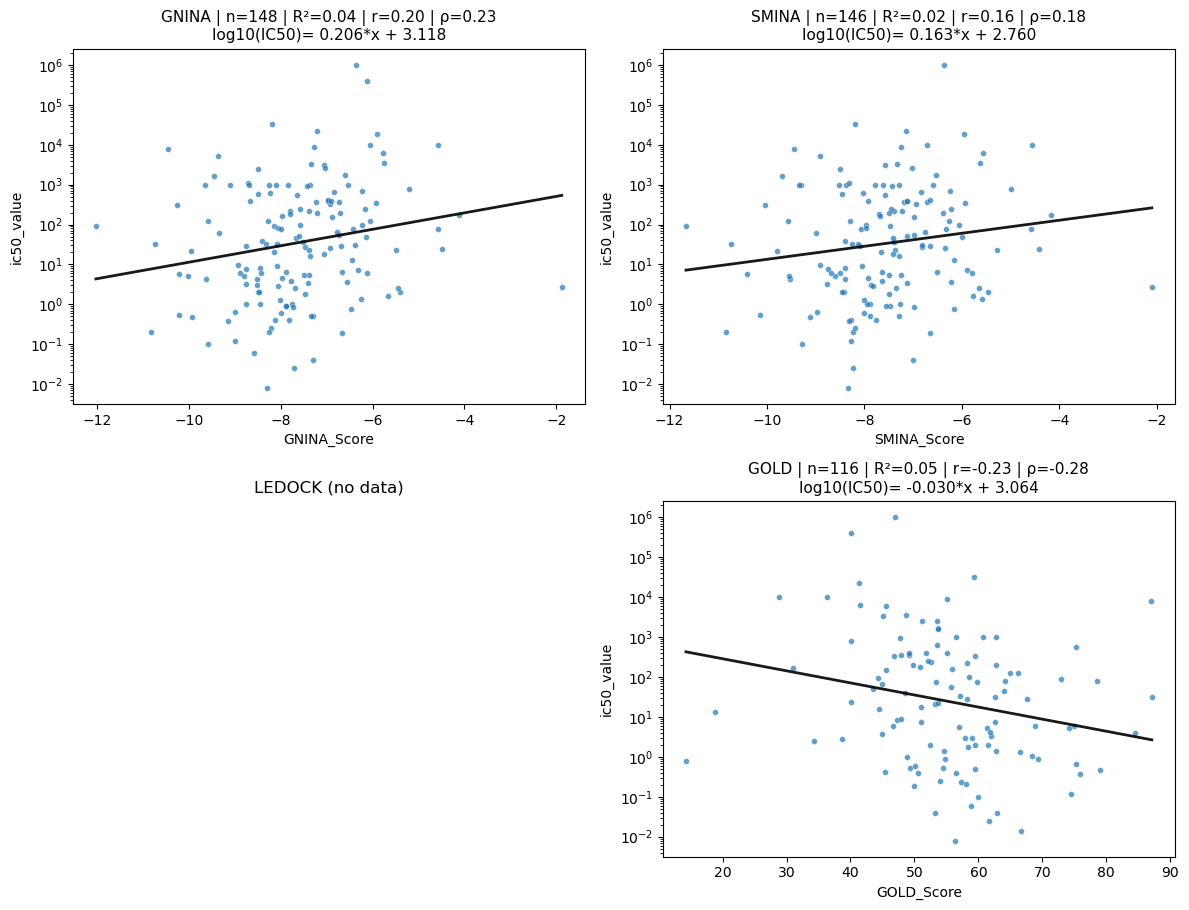

,tool,n,slope_m,intercept_b,r2,pearson_r,spearman_r
0,GNINA,148,0.206072,3.117557,0.039795,0.199488,0.229947
1,SMINA,146,0.163081,2.760019,0.024648,0.156997,0.175492
2,LEDOCK,0,NaN,NaN,NaN,NaN,NaN
3,GOLD,116,-0.030275,3.064119,0.052677,-0.229514,-0.282536


In [51]:
# IC50 vs docking scores (scatter + log10(IC50) trendline) for multiple tools

def _plot_ic50_vs_score(ax, pdf: pd.DataFrame, score_col: str, title: str) -> dict:
    """Plot scatter + log-linear trendline and return fit/correlation diagnostics."""
    pdf = pdf.dropna(subset=[score_col, 'ic50_value']).copy()
    pdf = pdf[pdf['ic50_value'] > 0]  # required for log-scale fit
    if pdf.empty:
        ax.set_title(f"{title} (no IC50)")
        ax.axis('off')
        return {'tool': title, 'n': 0}

    # Fit: log10(IC50) = m*x + b
    x = pdf[score_col].astype(float).to_numpy()
    logy = np.log10(pdf['ic50_value'].astype(float).to_numpy())

    # Remove non-finite just in case
    mask = np.isfinite(x) & np.isfinite(logy)
    x = x[mask]
    logy = logy[mask]
    if x.size < 3:
        ax.set_title(f"{title} (n<3)")
        ax.axis('off')
        return {'tool': title, 'n': int(x.size)}

    m, b = np.polyfit(x, logy, 1)
    x_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
    y_line = 10 ** (m * x_line + b)

    # Diagnostics
    pred = m * x + b
    ss_res = float(np.sum((logy - pred) ** 2))
    ss_tot = float(np.sum((logy - np.mean(logy)) ** 2))
    r2 = float('nan') if ss_tot == 0 else float(1.0 - ss_res / ss_tot)
    pearson_r = float(pd.Series(x).corr(pd.Series(logy), method='pearson'))
    spearman_r = float(pd.Series(x).corr(pd.Series(logy), method='spearman'))

    sns.scatterplot(data=pdf, x=score_col, y='ic50_value', alpha=0.7, s=18, ax=ax)
    ax.plot(x_line, y_line, color='black', linewidth=2, alpha=0.9)
    ax.set_yscale('log')
    ax.set_xlabel(score_col)
    ax.set_ylabel('ic50_value')
    ax.set_title(
        f"{title} | n={x.size} | R²={r2:.2f} | r={pearson_r:.2f} | ρ={spearman_r:.2f}\n"
        f"log10(IC50)= {m:.3f}*x + {b:.3f}",
        fontsize=11,
    )

    return {
        'tool': title,
        'n': int(x.size),
        'slope_m': float(m),
        'intercept_b': float(b),
        'r2': r2,
        'pearson_r': pearson_r,
        'spearman_r': spearman_r,
    }

# Which (pair-level) tool tables to use
tool_specs = [
    ('GNINA', df_gnina,  'GNINA_Score'),
    ('SMINA', df_smina,  'SMINA_Score'),
    ('LEDOCK', df_ledock,'Ledock_Score'),
    ('GOLD',  df_gold,   'GOLD_Score'),
 ]

# Build a subplot grid
n = len(tool_specs)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4.6 * nrows))
axes = np.array(axes).reshape(-1)

rows = []
for i, (tool, df_tool, score_col) in enumerate(tool_specs):
    ax = axes[i]
    if df_tool is None or df_tool.is_empty():
        ax.set_title(f"{tool} (no data)")
        ax.axis('off')
        rows.append({'tool': tool, 'n': 0})
        continue
    if 'ic50_value' not in df_tool.columns:
        ax.set_title(f"{tool} (ic50_value missing)")
        ax.axis('off')
        rows.append({'tool': tool, 'n': 0})
        continue
    if score_col not in df_tool.columns:
        ax.set_title(f"{tool} ({score_col} missing)")
        ax.axis('off')
        rows.append({'tool': tool, 'n': 0})
        continue

    pdf = df_tool.select([score_col, 'ic50_value']).to_pandas()
    rows.append(_plot_ic50_vs_score(ax, pdf, score_col=score_col, title=tool))

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Table summary of fit/correlation stats
stats_df = pd.DataFrame(rows)
display(stats_df)

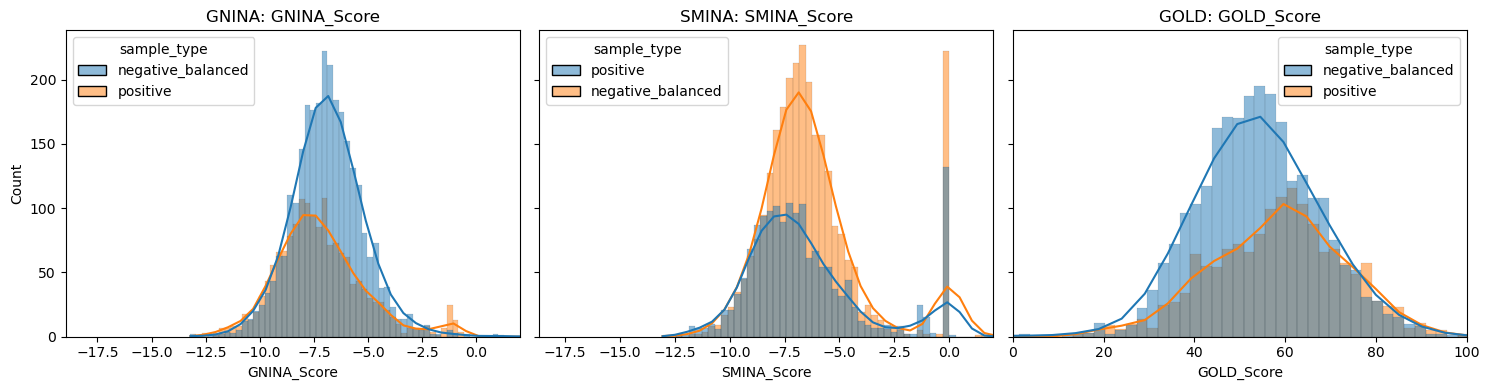

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

plots = [
    ("GNINA", df_gnina, "GNINA_Score"),
    ("SMINA", df_smina, "SMINA_Score"),
    ("GOLD",  df_gold,  "GOLD_Score"),
]

for ax, (tool, df_tool, score_col) in zip(axes, plots):
    sns.histplot(
        data=df_tool.to_pandas(),
        x=score_col,
        hue=LABEL_COL,
        #hue='louvain_cluster_pmax04' if 'louvain_cluster_pmax04' in df_tool.columns else None,
        kde=True,
        ax=ax,
    )
    ax.set_title(f"{tool}: {score_col}")
    ax.set_xlabel(score_col)
    ax.set_ylabel("Count")

# Keep your original GNINA limit
axes[0].set_xlim(right=2)
axes[1].set_xlim(right=2)
axes[2].set_xlim(left=0, right=100)

plt.tight_layout()
plt.show()

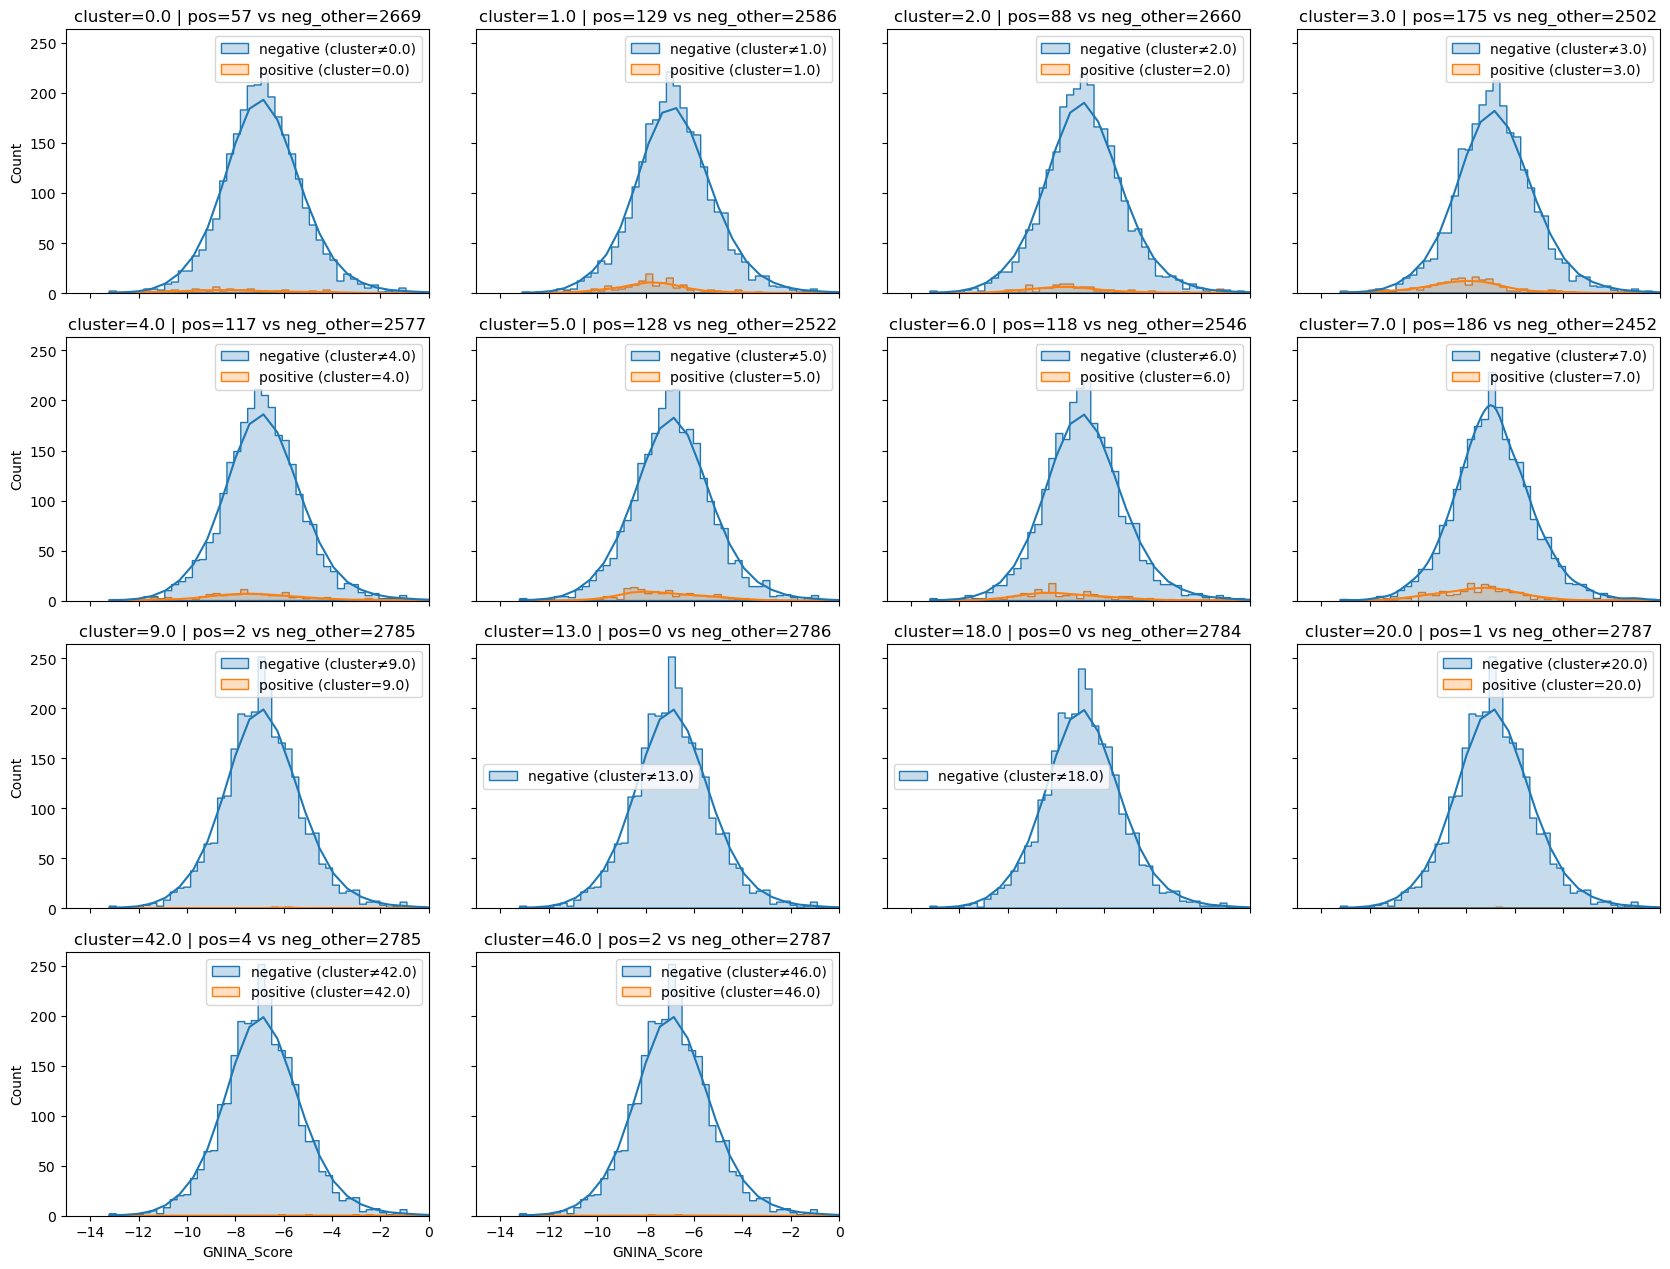

In [8]:
# Per-cluster focus plots: positives in cluster vs negatives in other clusters
cluster_col = 'louvain_cluster_pmax07'
df_tool = df_gnina  # change to df_smina / df_gold / df_ledock if desired
score_col = 'GNINA_Score'  # adjust if you change df_tool
ax_lim_left = -15
ax_lim_right = 0
EXCLUDE_MISSING_CLUSTER = True  # if True, drops cluster == -1

if cluster_col not in df_tool.columns:
    raise ValueError(f"{cluster_col} not in df_tool columns: {df_tool.columns}")
if score_col not in df_tool.columns:
    raise ValueError(f"{score_col} not in df_tool columns: {df_tool.columns}")

pdf = df_tool.select([score_col, LABEL_COL, cluster_col]).to_pandas()
pdf = pdf.dropna(subset=[score_col, LABEL_COL, cluster_col])

clusters = sorted(pd.unique(pdf[cluster_col]).tolist())
if EXCLUDE_MISSING_CLUSTER:
    clusters = [c for c in clusters if c != -1]
if not clusters:
    raise ValueError('No clusters found after filtering.')

n = len(clusters)
ncols = 4 if n >= 4 else n
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4.2 * ncols, 3.2 * nrows), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)

for i, cl in enumerate(clusters):
    ax = axes[i]
    pos_mask = (pdf[LABEL_COL] == 'positive') & (pdf[cluster_col] == cl)
    neg_mask = (pdf[LABEL_COL] == 'negative_balanced') & (pdf[cluster_col] != cl)
    focus = pdf[pos_mask | neg_mask].copy()
    focus['focus_hue'] = np.where(
        (focus[LABEL_COL] == 'positive') & (focus[cluster_col] == cl),
        f'positive (cluster={cl})',
        f'negative (cluster≠{cl})',
    )

    if focus.empty:
        ax.set_title(f'cluster={cl} (no data)')
        ax.axis('off')
        continue

    sns.histplot(
        data=focus,
        x=score_col,
        hue='focus_hue',
        kde=True,
        ax=ax,
        element='step',
        stat='count',
        common_norm=False,
    )
    n_pos = int(((focus[LABEL_COL] == 'positive') & (focus[cluster_col] == cl)).sum())
    n_neg = int(((focus[LABEL_COL] == 'negative_balanced') & (focus[cluster_col] != cl)).sum())
    ax.set_title(f'cluster={cl} | pos={n_pos} vs neg_other={n_neg}')
    ax.set_xlabel(score_col)
    ax.set_ylabel('Count')
    ax.set_xlim(left=ax_lim_left, right=ax_lim_right)
    ax.legend_.set_title('') if ax.legend_ else None

# Turn off any remaining unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

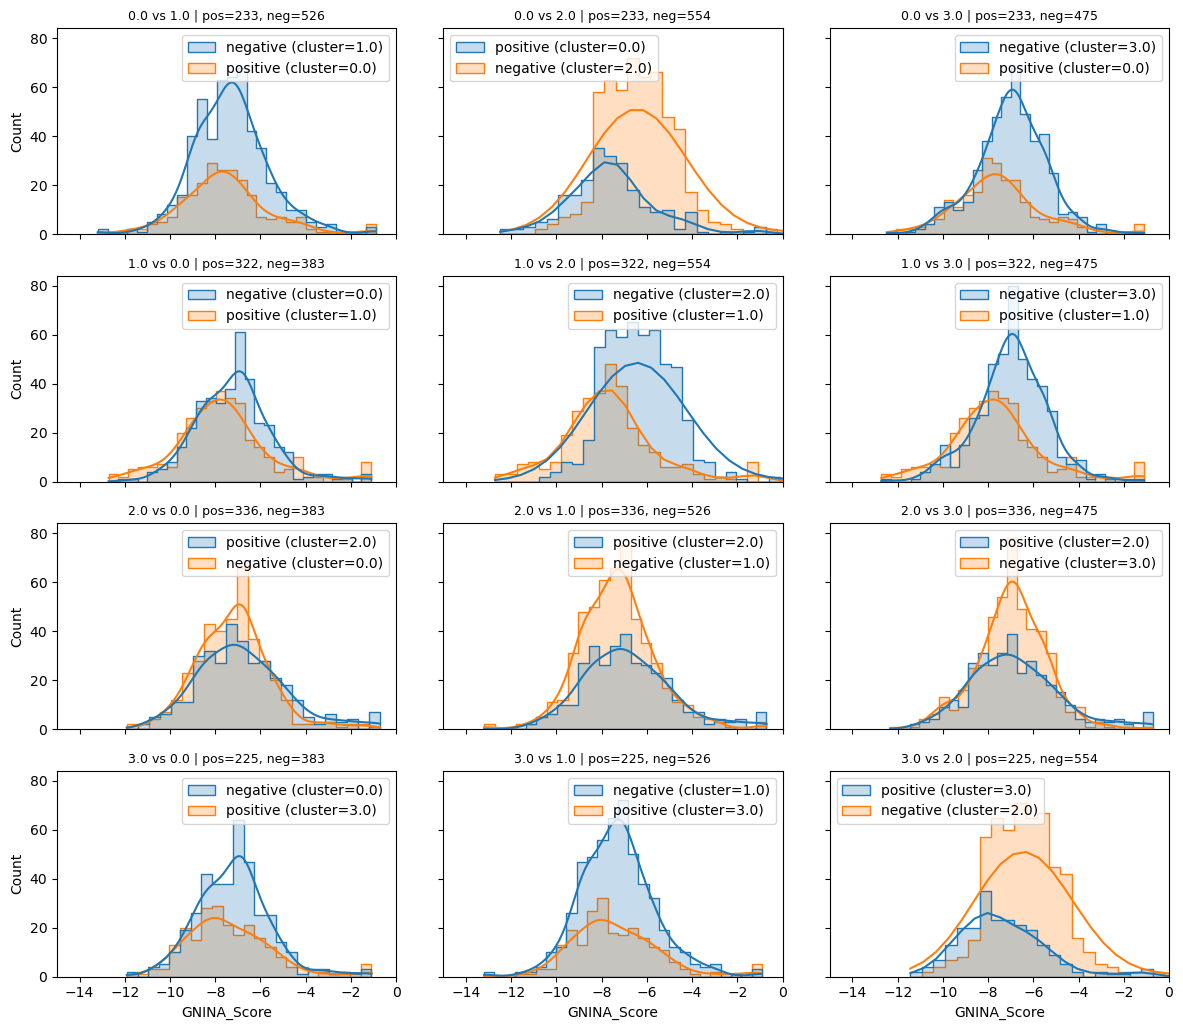

In [10]:
# Pairwise cluster separation plots: positives in focal cluster vs negatives in each other cluster
cluster_col = 'louvain_cluster_pmax04'
df_tool = df_gnina  # change to df_gnina / df_gold / df_ledock if desired
score_col = 'GNINA_Score'  # adjust if you change df_tool
ax_lim_left = -15
ax_lim_right = 0
EXCLUDE_MISSING_CLUSTER = True  # drops cluster == -1
MAX_CLUSTERS = None  # set e.g. 8 to cap figure size

if cluster_col not in df_tool.columns:
    raise ValueError(f"{cluster_col} not in df_tool columns: {df_tool.columns}")
if score_col not in df_tool.columns:
    raise ValueError(f"{score_col} not in df_tool columns: {df_tool.columns}")

pdf = df_tool.select([score_col, LABEL_COL, cluster_col]).to_pandas()
pdf = pdf.dropna(subset=[score_col, LABEL_COL, cluster_col])

clusters = sorted(pd.unique(pdf[cluster_col]).tolist())
if EXCLUDE_MISSING_CLUSTER:
    clusters = [c for c in clusters if c != -1]
if MAX_CLUSTERS is not None and len(clusters) > MAX_CLUSTERS:
    print(f"Too many clusters ({len(clusters)}); limiting to first {MAX_CLUSTERS}.")
    clusters = clusters[:MAX_CLUSTERS]
if len(clusters) < 2:
    raise ValueError('Need at least 2 clusters for pairwise plots.')

# Build an (n_clusters) x (n_clusters-1) grid: rows=focal cluster, cols=negative cluster (excluding focal)
n = len(clusters)
nrows = n
ncols = n - 1
fig_w = max(12, 3.2 * ncols)
fig_h = max(4, 2.6 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), sharex=True, sharey=True)
axes = np.array(axes)
if axes.ndim == 1:
    axes = axes.reshape(1, -1)

for i, focal in enumerate(clusters):
    other_clusters = [c for c in clusters if c != focal]
    for j, neg_cl in enumerate(other_clusters):
        ax = axes[i, j]
        pos_mask = (pdf[LABEL_COL] == 'positive') & (pdf[cluster_col] == focal)
        neg_mask = (pdf[LABEL_COL] == 'negative_balanced') & (pdf[cluster_col] == neg_cl)
        focus = pdf[pos_mask | neg_mask].copy()
        focus['focus_hue'] = np.where(
            (focus[LABEL_COL] == 'positive') & (focus[cluster_col] == focal),
            f'positive (cluster={focal})',
            f'negative (cluster={neg_cl})',
        )

        n_pos = int(((focus[LABEL_COL] == 'positive') & (focus[cluster_col] == focal)).sum())
        n_neg = int(((focus[LABEL_COL] == 'negative_balanced') & (focus[cluster_col] == neg_cl)).sum())
        if focus.empty or (n_pos == 0 and n_neg == 0):
            ax.set_title(f'{focal} vs {neg_cl} (no data)')
            ax.axis('off')
            continue

        sns.histplot(
            data=focus,
            x=score_col,
            hue='focus_hue',
            kde=True,
            ax=ax,
            element='step',
            stat='count',
            common_norm=False,
        )
        ax.set_title(f'{focal} vs {neg_cl} | pos={n_pos}, neg={n_neg}', fontsize=9)
        ax.set_xlabel(score_col)
        ax.set_ylabel('Count')
        ax.set_xlim(left=ax_lim_left, right=ax_lim_right)
        ax.legend_.set_title('') if ax.legend_ else None

plt.tight_layout()
plt.show()

In [12]:
# Template: Top-k accuracy (hit@k) for target prediction + candidate-set diagnostics
# Definition: hit@k = % of query compounds with ≥1 known target ranked in top-k

# Choose which tool dataframe + score you want to evaluate
df_tool = df_gnina
score_col = 'GNINA_Score'
lower_is_better = True  # GNINA/SMINA/LeDock: True; GOLD: False
KS = [1, 5, 10]

import math

def _log_choose(n: int, k: int) -> float:
    """log(C(n,k)) computed via lgamma; stable for large n."""
    if k < 0 or k > n:
        return float('-inf')
    # C(n, k) = exp(lgamma(n+1)-lgamma(k+1)-lgamma(n-k+1))
    return math.lgamma(n + 1) - math.lgamma(k + 1) - math.lgamma(n - k + 1)

def _random_hit_prob(n_candidates: int, n_known: int, k: int) -> float:
    """Probability that a random top-k contains ≥1 of n_known positives among n_candidates."""
    if n_candidates <= 0 or n_known <= 0 or k <= 0:
        return 0.0
    k = min(k, n_candidates)
    # If k draws exceed the number of non-known targets, a hit is guaranteed
    if k > (n_candidates - n_known):
        return 1.0
    # P(no hit) = C(n_candidates - n_known, k) / C(n_candidates, k)
    log_no_hit = _log_choose(n_candidates - n_known, k) - _log_choose(n_candidates, k)
    # Clamp for numerical safety
    log_no_hit = max(min(log_no_hit, 0.0), -750.0)
    p_no_hit = float(math.exp(log_no_hit))
    return float(1.0 - p_no_hit)

def topk_accuracy_with_diagnostics(
    df_tool: pl.DataFrame,
    score_col: str,
    ks: list[int],
    lower_is_better: bool,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Return (per_drug_table, summary_table).

    per_drug_table has one row per drug with hit@k indicators, candidate-set sizes, and random-baseline probs.
    summary_table reports mean hit rate across drugs + candidate-set distribution stats + random baseline.
    """
    if score_col not in df_tool.columns:
        raise ValueError(f"{score_col} not in df_tool columns")

    keep = [DRUG_COL, TGT_COL, LABEL_COL, score_col]
    pdf = df_tool.select([c for c in keep if c in df_tool.columns]).to_pandas()
    pdf = pdf.dropna(subset=[DRUG_COL, TGT_COL, LABEL_COL, score_col])
    if pdf.empty:
        raise ValueError('No rows after dropping nulls')

    ks = sorted({int(k) for k in ks if int(k) > 0})
    if not ks:
        raise ValueError('ks must contain positive integers')
    max_k = max(ks)

    rows = []
    for drug, g in pdf.groupby(DRUG_COL, sort=False):
        # Known targets for this drug (positives)
        known = set(g.loc[g[LABEL_COL] == 'positive', TGT_COL].astype(str).tolist())
        if not known:
            # Only count query compounds that have at least one known target
            continue

        # Candidate targets available for this drug (in this df_tool + non-null score)
        cand_targets = g[TGT_COL].astype(str).dropna().unique().tolist()
        n_candidates = int(len(cand_targets))
        n_known = int(len(known))
        if n_candidates == 0:
            continue

        # Rank targets by docking score
        ranked = (
            g[[TGT_COL, score_col]]
            .dropna(subset=[TGT_COL, score_col])
            .sort_values(score_col, ascending=lower_is_better)
        )
        ranked_targets = ranked[TGT_COL].astype(str).tolist()[:max_k]

        row = {
            DRUG_COL: drug,
            'n_candidates': n_candidates,
            'n_known_targets': n_known,
        }
        for k in ks:
            row[f'hit@{k}'] = int(any(t in known for t in ranked_targets[:k]))
            row[f'random_hit_prob@{k}'] = _random_hit_prob(n_candidates=n_candidates, n_known=n_known, k=k)
        rows.append(row)

    per_drug = pd.DataFrame(rows)
    if per_drug.empty:
        raise ValueError('No query drugs with known targets found (no positives per drug).')

    # Candidate-set diagnostics
    cand_stats = {
        'n_queries': int(len(per_drug)),
        'score_col': score_col,
        'lower_is_better': bool(lower_is_better),
        'mean_n_candidates': float(per_drug['n_candidates'].mean()),
        'median_n_candidates': float(per_drug['n_candidates'].median()),
        'p90_n_candidates': float(per_drug['n_candidates'].quantile(0.90)),
        'mean_n_known_targets': float(per_drug['n_known_targets'].mean()),
        'median_n_known_targets': float(per_drug['n_known_targets'].median()),
    }
    for k in ks:
        cand_stats[f'top{k}_acc'] = float(per_drug[f'hit@{k}'].mean())
        cand_stats[f'top{k}_n_hits'] = int(per_drug[f'hit@{k}'].sum())
        # Random baseline expectation averaged over drugs (accounts for varying candidate sizes)
        cand_stats[f'random_top{k}_acc'] = float(per_drug[f'random_hit_prob@{k}'].mean())

    summary_df = pd.DataFrame([cand_stats])
    return per_drug, summary_df

per_drug_hits, topk_summary = topk_accuracy_with_diagnostics(
    df_tool, score_col=score_col, ks=KS, lower_is_better=lower_is_better
)
display(topk_summary)

print('Candidate targets per drug (distribution over query drugs):')
print(per_drug_hits['n_candidates'].describe(percentiles=[0.5, 0.9, 0.95]).to_string())

for k in KS:
    obs = 100.0 * float(topk_summary.loc[0, f'top{k}_acc'])
    rnd = 100.0 * float(topk_summary.loc[0, f'random_top{k}_acc'])
    print(f"For {obs:.1f}% of molecules, ≥1 known target ranked in top-{k} (random baseline ≈ {rnd:.1f}%).")

,n_queries,score_col,lower_is_better,mean_n_candidates,median_n_candidates,p90_n_candidates,mean_n_known_targets,median_n_known_targets,top1_acc,top1_n_hits,random_top1_acc,top5_acc,top5_n_hits,random_top5_acc,top10_acc,top10_n_hits,random_top10_acc
0,484,GNINA_Score,True,9.107438,7.0,18.0,3.349174,2.0,0.508264,246,0.368447,0.948347,459,0.901862,0.989669,479,0.985246


Candidate targets per drug (distribution over query drugs):
count    484.000000
mean       9.107438
std        9.558192
min        2.000000
50%        7.000000
90%       18.000000
95%       22.000000
max      153.000000
For 50.8% of molecules, ≥1 known target ranked in top-1 (random baseline ≈ 36.8%).
For 94.8% of molecules, ≥1 known target ranked in top-5 (random baseline ≈ 90.2%).
For 99.0% of molecules, ≥1 known target ranked in top-10 (random baseline ≈ 98.5%).


In [8]:
# Consensus score (per pose) via 0-1 normalization, then Top-k on pair-level best consensus

# Key idea: normalize each tool to [0,1] where 1=best, then sum equally per pose.
# NOTE: In Polars you cannot reference columns created earlier in the same `with_columns` call,
# so we compute norm columns first, then consensus in a second pass.

import os
import math
import numpy as np
import pandas as pd
import polars as pl

# --- Fallback config for kernel restarts (uses the same defaults as your Config cell)
DEFAULT_DATA_FILE = (
    '/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/'
    'combined_filtered_annotated_docking_results.parquet'
)

if 'DATA_FILE' not in globals():
    DATA_FILE = DEFAULT_DATA_FILE
if 'DRUG_COL' not in globals():
    DRUG_COL = 'drugbank_id'
if 'TGT_COL' not in globals():
    TGT_COL = 'uniprot_id'
if 'LABEL_COL' not in globals():
    LABEL_COL = 'sample_type'
if 'PAIR_COL' not in globals():
    PAIR_COL = 'compound_target_pair'

# --- Load df if missing
if 'df' not in globals() or df is None:
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(f"DATA_FILE not found: {DATA_FILE}")
    df = pl.scan_parquet(DATA_FILE).collect()

# --- Basic validation
for _c in [DRUG_COL, TGT_COL, LABEL_COL]:
    if _c not in df.columns:
        raise ValueError(f"Missing required column in df: {_c}")
if PAIR_COL not in df.columns:
    df = df.with_columns(
        (pl.col(DRUG_COL).cast(pl.Utf8) + pl.lit('_') + pl.col(TGT_COL).cast(pl.Utf8)).alias(PAIR_COL)
    )

# Optional: restrict to the label set we care about (match earlier logic if present)
if LABEL_COL in df.columns:
    df = df.filter(pl.col(LABEL_COL).is_in(['positive', 'negative_balanced']))

# --- Tool column detection (handles naming variants)
def _first_existing(candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

# (score_col, lower_is_better)
tool_candidates: list[tuple[list[str], bool]] = [
    (['GNINA_Score'], True),
    (['SMINA_Score', 'Smina_Score'], True),
    (['Ledock_Score', 'LeDock_Score'], True),
    (['GOLD_Score'], False),
 ]

tool_cols: list[tuple[str, bool]] = []
for cand_cols, lower_is_better in tool_candidates:
    col = _first_existing(cand_cols)
    if col is not None:
        tool_cols.append((col, lower_is_better))

if not tool_cols:
    raise ValueError(
        "No tool score columns found. Tried GNINA_Score, (SMINA_Score|Smina_Score), "
        "(Ledock_Score|LeDock_Score), GOLD_Score."
    )

def _std_expr(col: str, lower_is_better: bool) -> pl.Expr:
    """Standardize to 'higher is better' and null-out non-finite values."""
    x = pl.col(col).cast(pl.Float64)
    x = pl.when(x.is_finite()).then(x).otherwise(None)
    return (-x) if lower_is_better else x

# --- Compute global min/max per tool on standardized scale
stat_exprs: list[pl.Expr] = []
for col, lower_is_better in tool_cols:
    s = _std_expr(col, lower_is_better)
    stat_exprs.append(s.min().alias(f'{col}__std_min'))
    stat_exprs.append(s.max().alias(f'{col}__std_max'))

stats_row = df.select(stat_exprs).row(0)
stats_cols = df.select(stat_exprs).columns
stats = dict(zip(stats_cols, stats_row))

# --- Build per-tool normalized columns in [0,1] where 0=worst, 1=best
norm_cols: list[str] = []
norm_exprs: list[pl.Expr] = []
for col, lower_is_better in tool_cols:
    s = _std_expr(col, lower_is_better)
    mn_raw = stats.get(f'{col}__std_min')
    mx_raw = stats.get(f'{col}__std_max')
    mn = float(mn_raw) if mn_raw is not None else float('nan')
    mx = float(mx_raw) if mx_raw is not None else float('nan')
    denom = mx - mn
    out_col = f'{col}__norm01'
    norm_cols.append(out_col)

    if not np.isfinite(mn) or not np.isfinite(mx) or denom == 0.0:
        # Degenerate/constant/undefined tool score -> set to 0.5 wherever the tool has a valid value
        norm_exprs.append(pl.when(s.is_null()).then(None).otherwise(pl.lit(0.5)).alias(out_col))
    else:
        norm_exprs.append(((s - pl.lit(mn)) / pl.lit(denom)).clip(0.0, 1.0).alias(out_col))

# IMPORTANT: two-stage with_columns (Polars cannot reference freshly-created columns in the same call)
df_cons = df.with_columns(norm_exprs)

# --- Consensus per-pose: equally weighted sum of available normalized tool scores
consensus_sum_col = 'CONSENSUS_Score'
consensus_n_col = 'CONSENSUS_n_tools'

df_cons = df_cons.with_columns([
    pl.sum_horizontal([pl.col(c).fill_null(0.0) for c in norm_cols]).alias(consensus_sum_col),
    pl.sum_horizontal([pl.col(c).is_not_null().cast(pl.Int8) for c in norm_cols]).alias(consensus_n_col),
])

print('Consensus tools used:', tool_cols)
print('Normalized columns:', norm_cols)
print(
    'Consensus per-pose range:',
    df_cons.select([
        pl.col(consensus_sum_col).min().alias('consensus_min'),
        pl.col(consensus_sum_col).max().alias('consensus_max'),
    ]),
)

# --- Aggregate to one row per (drug,target) pair using best consensus across poses (higher=better)
df_cons_pair = (
    df_cons
    .filter(pl.col(consensus_n_col) > 0)
    .group_by(PAIR_COL)
    .agg([
        pl.first(DRUG_COL).alias(DRUG_COL),
        pl.first(TGT_COL).alias(TGT_COL),
        pl.first(LABEL_COL).alias(LABEL_COL),
        pl.max(consensus_sum_col).alias(consensus_sum_col),
        pl.max(consensus_n_col).alias(consensus_n_col),
    ])
)
print('Pair-level consensus rows:', df_cons_pair.height)

# --- Top-k diagnostics on consensus (higher is better => lower_is_better=False)
KS = TOP_KS if 'TOP_KS' in globals() else [1, 5, 10]

def _log_choose(n: int, k: int) -> float:
    if k < 0 or k > n:
        return float('-inf')
    return math.lgamma(n + 1) - math.lgamma(k + 1) - math.lgamma(n - k + 1)

def _random_hit_prob(n_candidates: int, n_known: int, k: int) -> float:
    if n_candidates <= 0 or n_known <= 0 or k <= 0:
        return 0.0
    k = min(k, n_candidates)
    if k > (n_candidates - n_known):
        return 1.0
    log_no_hit = _log_choose(n_candidates - n_known, k) - _log_choose(n_candidates, k)
    log_no_hit = max(min(log_no_hit, 0.0), -750.0)
    return float(1.0 - math.exp(log_no_hit))

if 'topk_accuracy_with_diagnostics' not in globals():
    def topk_accuracy_with_diagnostics(
        df_tool: pl.DataFrame,
        score_col: str,
        ks: list[int],
        lower_is_better: bool,
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
        if score_col not in df_tool.columns:
            raise ValueError(f"{score_col} not in df_tool columns")
        keep = [DRUG_COL, TGT_COL, LABEL_COL, score_col]
        pdf = df_tool.select([c for c in keep if c in df_tool.columns]).to_pandas()
        pdf = pdf.dropna(subset=[DRUG_COL, TGT_COL, LABEL_COL, score_col])
        if pdf.empty:
            raise ValueError('No rows after dropping nulls')
        ks = sorted({int(k) for k in ks if int(k) > 0})
        if not ks:
            raise ValueError('ks must contain positive integers')
        max_k = max(ks)

        rows = []
        for drug, g in pdf.groupby(DRUG_COL, sort=False):
            known = set(g.loc[g[LABEL_COL] == 'positive', TGT_COL].astype(str).tolist())
            if not known:
                continue
            cand_targets = g[TGT_COL].astype(str).dropna().unique().tolist()
            n_candidates = int(len(cand_targets))
            n_known = int(len(known))
            if n_candidates == 0:
                continue

            ranked = (
                g[[TGT_COL, score_col]]
                .dropna(subset=[TGT_COL, score_col])
                .sort_values(score_col, ascending=lower_is_better)
            )
            ranked_targets = ranked[TGT_COL].astype(str).tolist()[:max_k]

            row = {DRUG_COL: drug, 'n_candidates': n_candidates, 'n_known_targets': n_known}
            for k in ks:
                row[f'hit@{k}'] = int(any(t in known for t in ranked_targets[:k]))
                row[f'random_hit_prob@{k}'] = _random_hit_prob(n_candidates, n_known, k)
            rows.append(row)

        per_drug = pd.DataFrame(rows)
        if per_drug.empty:
            raise ValueError('No query drugs with known targets found (no positives per drug).')

        summary = {
            'n_queries': int(len(per_drug)),
            'score_col': score_col,
            'lower_is_better': bool(lower_is_better),
            'mean_n_candidates': float(per_drug['n_candidates'].mean()),
            'median_n_candidates': float(per_drug['n_candidates'].median()),
            'p90_n_candidates': float(per_drug['n_candidates'].quantile(0.90)),
            'mean_n_known_targets': float(per_drug['n_known_targets'].mean()),
            'median_n_known_targets': float(per_drug['n_known_targets'].median()),
        }
        for k in ks:
            summary[f'top{k}_acc'] = float(per_drug[f'hit@{k}'].mean())
            summary[f'top{k}_n_hits'] = int(per_drug[f'hit@{k}'].sum())
            summary[f'random_top{k}_acc'] = float(per_drug[f'random_hit_prob@{k}'].mean())
        return per_drug, pd.DataFrame([summary])

per_drug_hits_cons, topk_summary_cons = topk_accuracy_with_diagnostics(
    df_cons_pair, score_col=consensus_sum_col, ks=KS, lower_is_better=False
 )
display(topk_summary_cons)

print('Candidate targets per drug (distribution over query drugs):')
print(per_drug_hits_cons['n_candidates'].describe(percentiles=[0.5, 0.9, 0.95]).to_string())
for k in KS:
    obs = 100.0 * float(topk_summary_cons.loc[0, f'top{k}_acc'])
    rnd = 100.0 * float(topk_summary_cons.loc[0, f'random_top{k}_acc'])
    print(f"Consensus: For {obs:.1f}% of molecules, ≥1 known target ranked in top-{k} (random baseline ≈ {rnd:.1f}%).")

Consensus tools used: [('GNINA_Score', True), ('SMINA_Score', True), ('LeDock_Score', True), ('GOLD_Score', False)]
Normalized columns: ['GNINA_Score__norm01', 'SMINA_Score__norm01', 'LeDock_Score__norm01', 'GOLD_Score__norm01']
Consensus per-pose range: shape: (1, 2)
┌───────────────┬───────────────┐
│ consensus_min ┆ consensus_max │
│ ---           ┆ ---           │
│ f64           ┆ f64           │
╞═══════════════╪═══════════════╡
│ 0.0           ┆ 1.999443      │
└───────────────┴───────────────┘
Pair-level consensus rows: 4408


,n_queries,score_col,lower_is_better,mean_n_candidates,median_n_candidates,p90_n_candidates,mean_n_known_targets,median_n_known_targets,top1_acc,top1_n_hits,random_top1_acc,top5_acc,top5_n_hits,random_top5_acc,top10_acc,top10_n_hits,random_top10_acc
0,484,CONSENSUS_Score,False,9.107438,7.0,18.0,3.349174,2.0,0.502066,243,0.368447,0.946281,458,0.901862,0.995868,482,0.985246


Candidate targets per drug (distribution over query drugs):
count    484.000000
mean       9.107438
std        9.558192
min        2.000000
50%        7.000000
90%       18.000000
95%       22.000000
max      153.000000
Consensus: For 50.2% of molecules, ≥1 known target ranked in top-1 (random baseline ≈ 36.8%).
Consensus: For 94.6% of molecules, ≥1 known target ranked in top-5 (random baseline ≈ 90.2%).
Consensus: For 99.6% of molecules, ≥1 known target ranked in top-10 (random baseline ≈ 98.5%).


In [9]:
# Side-by-side Top-k comparison: per-tool vs CONSENSUS

# This cell expects that:
# - `df` is the row-level polars DataFrame
# - `topk_accuracy_with_diagnostics` is defined (Cell 11), otherwise we fall back to a minimal version
# - `df_cons_pair` + `CONSENSUS_Score` exist (from the previous cell)

import pandas as pd
import polars as pl

KS = TOP_KS if 'TOP_KS' in globals() else [1, 5, 10]

if 'topk_accuracy_with_diagnostics' not in globals():
    # Fallback: minimal (same logic as earlier template)
    import math

    def _log_choose(n: int, k: int) -> float:
        if k < 0 or k > n:
            return float('-inf')
        return math.lgamma(n + 1) - math.lgamma(k + 1) - math.lgamma(n - k + 1)

    def _random_hit_prob(n_candidates: int, n_known: int, k: int) -> float:
        if n_candidates <= 0 or n_known <= 0 or k <= 0:
            return 0.0
        k = min(k, n_candidates)
        if k > (n_candidates - n_known):
            return 1.0
        log_no_hit = _log_choose(n_candidates - n_known, k) - _log_choose(n_candidates, k)
        log_no_hit = max(min(log_no_hit, 0.0), -750.0)
        return float(1.0 - math.exp(log_no_hit))

    def topk_accuracy_with_diagnostics(
        df_tool: pl.DataFrame,
        score_col: str,
        ks: list[int],
        lower_is_better: bool,
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
        keep = [DRUG_COL, TGT_COL, LABEL_COL, score_col]
        pdf = df_tool.select([c for c in keep if c in df_tool.columns]).to_pandas()
        pdf = pdf.dropna(subset=[DRUG_COL, TGT_COL, LABEL_COL, score_col])
        ks = sorted({int(k) for k in ks if int(k) > 0})
        max_k = max(ks)
        rows = []
        for drug, g in pdf.groupby(DRUG_COL, sort=False):
            known = set(g.loc[g[LABEL_COL] == 'positive', TGT_COL].astype(str).tolist())
            if not known:
                continue
            cand_targets = g[TGT_COL].astype(str).dropna().unique().tolist()
            n_candidates = int(len(cand_targets))
            n_known = int(len(known))
            if n_candidates == 0:
                continue
            ranked = (
                g[[TGT_COL, score_col]]
                .dropna(subset=[TGT_COL, score_col])
                .sort_values(score_col, ascending=lower_is_better)
            )
            ranked_targets = ranked[TGT_COL].astype(str).tolist()[:max_k]
            row = {DRUG_COL: drug, 'n_candidates': n_candidates, 'n_known_targets': n_known}
            for k in ks:
                row[f'hit@{k}'] = int(any(t in known for t in ranked_targets[:k]))
                row[f'random_hit_prob@{k}'] = _random_hit_prob(n_candidates, n_known, k)
            rows.append(row)
        per_drug = pd.DataFrame(rows)
        summary = {
            'n_queries': int(len(per_drug)),
            'score_col': score_col,
            'lower_is_better': bool(lower_is_better),
            'mean_n_candidates': float(per_drug['n_candidates'].mean()),
            'median_n_candidates': float(per_drug['n_candidates'].median()),
            'p90_n_candidates': float(per_drug['n_candidates'].quantile(0.90)),
            'mean_n_known_targets': float(per_drug['n_known_targets'].mean()),
            'median_n_known_targets': float(per_drug['n_known_targets'].median()),
        }
        for k in ks:
            summary[f'top{k}_acc'] = float(per_drug[f'hit@{k}'].mean())
            summary[f'top{k}_n_hits'] = int(per_drug[f'hit@{k}'].sum())
            summary[f'random_top{k}_acc'] = float(per_drug[f'random_hit_prob@{k}'].mean())
        return per_drug, pd.DataFrame([summary])

def _pair_best_score(df_in: pl.DataFrame, score_col: str, best: str) -> pl.DataFrame:
    if score_col not in df_in.columns:
        return pl.DataFrame()
    agg_score = (pl.min(score_col) if best == 'min' else pl.max(score_col)).alias(score_col)
    return (
        df_in
        .filter(pl.col(score_col).is_not_null() & pl.col(score_col).is_finite())
        .group_by(PAIR_COL)
        .agg([
            pl.first(DRUG_COL).alias(DRUG_COL),
            pl.first(TGT_COL).alias(TGT_COL),
            pl.first(LABEL_COL).alias(LABEL_COL),
            agg_score,
        ])
    )

# Build pair-level tables if missing (or empty)
if 'df_gnina' not in globals() or df_gnina is None or (hasattr(df_gnina, 'is_empty') and df_gnina.is_empty()):
    df_gnina = _pair_best_score(df, 'GNINA_Score', best='min')
if 'df_smina' not in globals() or df_smina is None or (hasattr(df_smina, 'is_empty') and df_smina.is_empty()):
    # handle both naming variants
    smina_col = 'SMINA_Score' if 'SMINA_Score' in df.columns else ('Smina_Score' if 'Smina_Score' in df.columns else None)
    df_smina = _pair_best_score(df, smina_col, best='min') if smina_col else pl.DataFrame()
if 'df_ledock' not in globals() or df_ledock is None or (hasattr(df_ledock, 'is_empty') and df_ledock.is_empty()):
    ledock_col = 'Ledock_Score' if 'Ledock_Score' in df.columns else ('LeDock_Score' if 'LeDock_Score' in df.columns else None)
    df_ledock = _pair_best_score(df, ledock_col, best='min') if ledock_col else pl.DataFrame()
if 'df_gold' not in globals() or df_gold is None or (hasattr(df_gold, 'is_empty') and df_gold.is_empty()):
    df_gold = _pair_best_score(df, 'GOLD_Score', best='max')

# Prepare tool specs (pair-level df, score_col, lower_is_better)
tool_specs = []
if 'df_gnina' in globals() and df_gnina is not None and not df_gnina.is_empty():
    tool_specs.append(('GNINA', df_gnina, 'GNINA_Score', True))
if 'df_smina' in globals() and df_smina is not None and not df_smina.is_empty():
    sc = 'SMINA_Score' if 'SMINA_Score' in df_smina.columns else ('Smina_Score' if 'Smina_Score' in df_smina.columns else None)
    if sc:
        tool_specs.append(('SMINA', df_smina, sc, True))
if 'df_ledock' in globals() and df_ledock is not None and not df_ledock.is_empty():
    sc = 'Ledock_Score' if 'Ledock_Score' in df_ledock.columns else ('LeDock_Score' if 'LeDock_Score' in df_ledock.columns else None)
    if sc:
        tool_specs.append(('LEDOCK', df_ledock, sc, True))
if 'df_gold' in globals() and df_gold is not None and not df_gold.is_empty():
    tool_specs.append(('GOLD', df_gold, 'GOLD_Score', False))

# Add consensus if present
if 'df_cons_pair' in globals() and df_cons_pair is not None and not df_cons_pair.is_empty():
    if 'CONSENSUS_Score' in df_cons_pair.columns:
        tool_specs.append(('CONSENSUS', df_cons_pair, 'CONSENSUS_Score', False))

if not tool_specs:
    raise ValueError('No tool tables available to evaluate.')

# Compute summary rows
rows = []
for tool_name, df_tool, score_col, lower_is_better in tool_specs:
    _, summary = topk_accuracy_with_diagnostics(df_tool, score_col=score_col, ks=KS, lower_is_better=lower_is_better)
    r = summary.iloc[0].to_dict()
    r['tool'] = tool_name
    rows.append(r)

compare_df = pd.DataFrame(rows)

# Make it easier to scan: show top-k and baseline side-by-side
front = ['tool', 'n_queries', 'mean_n_candidates', 'median_n_candidates', 'p90_n_candidates', 'mean_n_known_targets']
metrics = []
for k in KS:
    metrics.extend([f'top{k}_acc', f'random_top{k}_acc'])
cols = [c for c in front + metrics if c in compare_df.columns]
compare_df = compare_df[cols].sort_values('tool')

display(compare_df)

,tool,n_queries,mean_n_candidates,median_n_candidates,p90_n_candidates,mean_n_known_targets,top1_acc,random_top1_acc,top5_acc,random_top5_acc,top10_acc,random_top10_acc
3,CONSENSUS,484,9.107438,7.0,18.0,3.349174,0.502066,0.368447,0.946281,0.901862,0.995868,0.985246
0,GNINA,484,9.107438,7.0,18.0,3.349174,0.508264,0.368447,0.948347,0.901862,0.989669,0.985246
2,GOLD,465,8.713978,6.0,18.0,3.270968,0.511828,0.377906,0.952688,0.913633,0.993548,0.987677
1,SMINA,481,9.010395,7.0,18.0,3.347193,0.490644,0.371087,0.933472,0.905201,0.985447,0.986018


In [6]:
DATA_ATLAS_FILE = "/media/onur/Elements/cavity_space_consensus_docking/2025_06_29_batch_dock/dta_atlas_data/home/madinasu/convertedData/dta_atlas_dataset_1_0/part.0.parquet"

df_atlas = pl.read_parquet(DATA_ATLAS_FILE)

print("Rows:", df_atlas.height)
print("Columns:", len(df_atlas.columns))

Rows: 1000000
Columns: 28


In [8]:
df_atlas.head()

__null_dask_index__,entry_id,uniprot_id,drugbank_id,DeepDTA_kd,DeepDTA_ki,DeepDTA_ic50,GAT_GCN_kd,GAT_GCN_ki,GAT_GCN_ic50,GCNNet_kd,GCNNet_ki,GCNNet_ic50,GINConvNet_kd,GINConvNet_ki,GINConvNet_ic50,MLTLE_GCN_kd,MLTLE_GCN_ki,MLTLE_GCN_ic50,MLTLE_GIN_kd,MLTLE_GIN_ki,MLTLE_GIN_ic50,avg_kd,avg_ki,avg_ic50,ci_kd,ci_ki,ci_ic50
i64,str,str,str,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,"""A0A024RBG1_DB00006""","""A0A024RBG1""","""DB00006""",4.6736,6.7386,4.9946,4.916966,6.363872,5.405446,4.503778,6.058082,4.948615,5.204148,8.888554,6.739195,7.4191,8.0336,8.5302,6.8885,6.805,7.803,5.601015,7.147951,6.403509,5.634092,7.141006,6.414255
1,"""A0A024RBG1_DB00007""","""A0A024RBG1""","""DB00007""",6.7337,8.5124,7.8012,5.14557,7.389182,4.738417,4.816043,5.522864,5.38624,5.038301,7.456189,5.732474,7.4894,8.5761,8.5162,7.2471,7.2325,8.4218,6.078352,7.448206,6.766055,6.088449,7.402771,6.718192
2,"""A0A024RBG1_DB00014""","""A0A024RBG1""","""DB00014""",7.836,5.923,8.1755,6.009164,7.119696,5.360075,4.964414,6.794137,5.444944,4.857752,7.874406,5.857607,7.5205,8.9688,8.4607,7.2372,7.152,8.2664,6.404172,7.30534,6.927538,6.401159,7.342397,6.880997
3,"""A0A024RBG1_DB00027""","""A0A024RBG1""","""DB00027""",5.2129,6.0704,4.5947,5.596216,7.044,5.233441,4.500264,6.495701,4.943516,5.84313,7.203681,6.230455,7.4378,7.5336,7.7057,6.3363,6.0764,6.6822,5.821102,6.737297,5.898335,5.839809,6.757845,5.913965
4,"""A0A024RBG1_DB00035""","""A0A024RBG1""","""DB00035""",6.7766,6.3906,4.6648,5.292438,6.841841,5.582236,5.118534,6.215602,4.77684,5.746962,8.496933,5.811235,7.0263,7.5983,8.5596,6.6247,6.5189,7.1131,6.097589,7.010363,6.084635,6.096673,7.016566,6.106763
